In [41]:
import gzip
from collections import defaultdict
import json
import numpy as np
from implicit import bpr
from surprise import SVD, Reader, Dataset
from surprise.model_selection import train_test_split,cross_validate
import pandas as pd
import matplotlib 
from matplotlib import pyplot as plt
matplotlib.rcParams['figure.figsize'] = (10, 4)
import skopt
from skopt import gp_minimize, forest_minimize
from skopt.space import Real, Categorical, Integer
from skopt.utils import use_named_args

In [34]:

def parse(path):
  g = gzip.open(path, 'r')
  for l in g:
    yield json.loads(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

df = getDF("Digital_Music_5.json.gz")

In [35]:
df = df[df['verified'] == True]
df = df[['asin','reviewerID','overall']]

In [36]:
df

,asin,reviewerID,overall
0,3426958910,A2TYZ821XXK2YZ,5.0
1,3426958910,A3OFSREZADFUDY,5.0
2,3426958910,A2VAMODP8M77NG,5.0
4,5557706259,A3OH43OZJLKI09,5.0
5,5557706259,A6JP9YYJCK3WO,4.0
...,...,...,...
169776,B01HJ91MTW,A1SR2T84IXOMAQ,5.0
169777,B01HJ91MTW,A2SR3DWJR1PYR6,5.0
169778,B01HJ91MTW,A24V7X30NIMOIY,5.0
169779,B01HJ91MTW,A1LW10GYP2EYM1,5.0


In [37]:
df.to_csv('ratings.csv',index=False)

<Axes: >

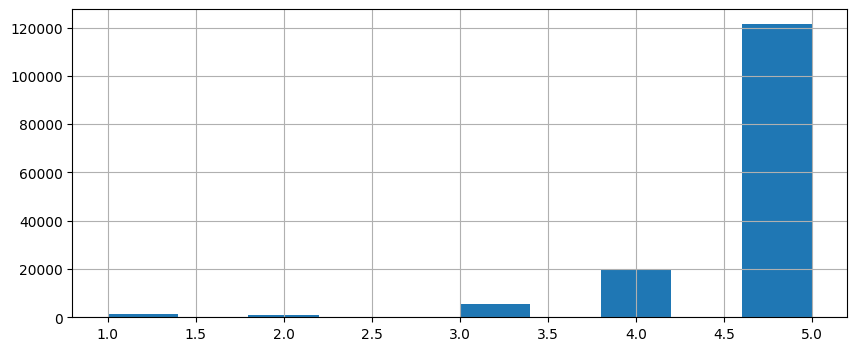

In [25]:
df['overall'].hist()

In [38]:
# helper functions
def MSE(y, ypred):
    differences = [(x-y)**2 for x,y in zip(ypred,y)]
    return sum(differences) / len(differences)

In [50]:
# global mean predictor
ratingMean = df['overall'].mean()
MSE(df['overall'].tolist()[-14000:],([5]*df.shape[0])[-14000:])

0.6306428571428572

In [47]:
############################################################################################
# time played prediction begins
ratings_file = "ratings.csv"

reader = Reader(line_format="item user rating", sep=",",rating_scale=(1,5))
data = Dataset.load_from_file(ratings_file, reader=reader)

trainset,testset = train_test_split(data, test_size=.1)
def validate(latent_factors, init_std_dev, lr_bu, lr_bi, lr_pu, lr_qi, reg_bu, reg_bi, reg_pu, reg_qi, n_iter):
    model = SVD(
            n_factors=latent_factors, 
            n_epochs=n_iter, 
            biased=True,
            init_mean=0,
            init_std_dev=init_std_dev,
            lr_all=None,
            reg_all=None,
            lr_bu=lr_bu,
            lr_bi=lr_bi,
            lr_pu=lr_pu,
            lr_qi=lr_qi,
            reg_bu=reg_bu,
            reg_bi=reg_bi,
            reg_pu=reg_pu,
            reg_qi=reg_qi,
            random_state=None, 
            verbose=False
        )
        
    model.fit(trainset)
    predictions = model.test(testset)
    
    sse = 0
    for p in predictions:
        sse += (p.r_ui - p.est)**2
    mse = sse / len(predictions)
    return mse
    
    # return cross_validate(model, data, measures=["MSE"], cv=10, verbose=True)

def tune():
    
    search_space = [
        # Real(1e-6, 0.01, prior = 'log-uniform', name = 'lamb'),
        # Integer(1, 2, name ='latent_factors'),
        Real(1e-5, 1e-2, prior = 'log-uniform', name ='lr_bu'),
        Real(1e-5, 1e-2, prior = 'log-uniform', name ='lr_bi'),
        Real(1e-5, 1e-2, prior = 'log-uniform', name ='lr_pu'),
        Real(1e-5, 1e-2, prior = 'log-uniform', name ='lr_qi'),
        Real(1e-7, 0.01, prior = 'log-uniform', name ='reg_bu'),
        Real(1e-7, 0.01, prior = 'log-uniform', name ='reg_bi'),
        Real(1e-7, 0.01, prior = 'log-uniform', name ='reg_pu'),
        Real(1e-7, 0.01, prior = 'log-uniform', name ='reg_qi'),
        Real(1e-4, 1e-2, prior = 'uniform', name ='init_std_dev'),
        Integer(20,100, name ='n_iter'),
    ]
    
    @use_named_args(dimensions=search_space)
    def objective(lr_bu, lr_bi, lr_pu, lr_qi, reg_bu, reg_bi, reg_pu, reg_qi, init_std_dev, n_iter):
        latent_factors = 0
        init_mean = 0
        print('calculating objective...')
        print(f'latent_factors={latent_factors}, lr_bu={lr_bu}, lr_bi={lr_bi}, lr_pu={lr_pu}, lr_qi={lr_qi},reg_bu={reg_bu},reg_bi={reg_bi},reg_pu={reg_pu},reg_qi={reg_qi}, n_iter={n_iter},init_mean={init_mean}, init_std_dev={init_std_dev}')
        
        # cv_result = validate(latent_factors, init_std_dev, lr_bu, lr_bi, lr_pu, lr_qi, reg_bu, reg_bi, reg_pu, reg_qi, n_iter)
        # mean_mse = np.mean(cv_result['test_mse'])
        # print(f'objective = {mean_mse}\n')
        # return mean_mse
        
        mse = validate(latent_factors, init_std_dev, lr_bu, lr_bi, lr_pu, lr_qi, reg_bu, reg_bi, reg_pu, reg_qi, n_iter)
        print(f'objective = {mse}\n')
        return mse
    
    default_parameters = [0.0046905221106103065,0.004707606265909147,0.00034357514547643595,0.0001,1e-6,1e-6,1e-6,1e-6,1e-3,40]
    search_result = gp_minimize(func=objective,
                            dimensions=search_space,
                            # acq_func='EI', # Expected Improvement.
                            n_calls=200,
                            x0=default_parameters)
    return search_result

tune()
    
# test()


calculating objective...
latent_factors=0, lr_bu=0.004690522110610306, lr_bi=0.004707606265909147, lr_pu=0.00034357514547643595, lr_qi=0.0001,reg_bu=1e-06,reg_bi=1e-06,reg_pu=1e-06,reg_qi=1e-06, n_iter=40,init_mean=0, init_std_dev=0.001
objective = 0.26001417883888633

calculating objective...
latent_factors=0, lr_bu=0.000724295720150329, lr_bi=0.003483731314608456, lr_pu=0.000920399061844154, lr_qi=0.00012109247375556908,reg_bu=4.685442755642311e-07,reg_bi=1.0297848952444362e-07,reg_pu=3.459047384984386e-05,reg_qi=0.0003236078906710453, n_iter=68,init_mean=0, init_std_dev=0.007364284956215628
objective = 0.3031391883485038

calculating objective...
latent_factors=0, lr_bu=0.004456189404719041, lr_bi=0.005272501656748818, lr_pu=2.6532679144096303e-05, lr_qi=0.0013515625501407794,reg_bu=0.00027650270542220457,reg_bi=0.008047090056189525,reg_pu=0.0009417248210710922,reg_qi=0.00028999645281331976, n_iter=30,init_mean=0, init_std_dev=0.004696406330403032
objective = 0.26583430265886904

ca

KeyboardInterrupt: 

In [ ]:
def test():
    
    # latent_factors=1
    # lr_bu=0.0010272161835192767
    # lr_bi=0.0029691351517760205
    # lr_pu=1e-05
    # lr_qi=0.01
    # reg_bu=1e-07
    # reg_bi=0.01
    # reg_pu=0.01
    # reg_qi=0.01
    # n_iter=75
    # init_mean=0
    # init_std_dev=0.001

    model = SVD(
        n_factors=latent_factors,
        n_epochs=n_iter, 
        biased=True,
        init_mean=init_mean,
        init_std_dev=init_std_dev,
        lr_all=None,
        reg_all=None,
        lr_bu=lr_bu,
        lr_bi=lr_bi,
        lr_pu=lr_pu,
        lr_qi=lr_qi,
        reg_bu=reg_bu,
        reg_bi=reg_bi,
        reg_pu=reg_pu,
        reg_qi=reg_qi,
        random_state=None, 
        verbose=False
    )
    trainset,testset = train_test_split(data, test_size=1e-20)
    model.fit(trainset)

    predictions = open("predictions_Hours.csv", 'w')
    for l in open("pairs_Hours.csv"):
        if l.startswith("userID"): 
            predictions.write(l)
        else:
            user,game = l.strip().split(',')
            prediction = model.predict(user,game,clip=False).est
            predictions.write(user + ',' + game + ',' + str(prediction) + '\n')
    predictions.close()
    